In [1]:
import drnb.embed.pipeline as pl

Using a custom UMAP gradient coefficient. In this case, the squared loss between the affinities rather than cross entropy.

In [2]:
from dataclasses import dataclass
from typing import NamedTuple

from drnb.embed.umap.custom2 import CustomGradientUMAP2, custom_umap, epoch_func


def squmap_grad_coeff_attr(d2, grad_args):
    return -2.0 * pow(1.0 + d2, -2.0)


def squmap_grad_coeff_rep(d2, grad_args):
    return 2.0 * pow(1.0 + d2, -3.0)


class SQUMAP(CustomGradientUMAP2):
    def get_gradient_args(self):
        return None

    def __init__(self, **kwargs):
        if "anneal_lr" not in kwargs:
            kwargs["anneal_lr"] = True
        super().__init__(
            custom_epoch_func=epoch_func,
            custom_attr_func=squmap_grad_coeff_attr,
            custom_rep_func=squmap_grad_coeff_rep,
            **kwargs,
        )

/home/james/dev/drnb3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[20:18:51] WARNING  151 nearest neighbors requested but only 150 items are available   ]8;id=746690;file:///home/james/dev/drnb3/src/drnb/eval/nbrpres.py\nbrpres.py]8;;\:]8;id=948133;file:///home/james/dev/drnb3/src/drnb/eval/nbrpres.py#80\80]8;;\

           INFO     Loading faiss with AVX2 support.                                   ]8;id=954333;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/faiss-1.9.0-py3.12.egg/faiss/loader.py\loader.py]8;;\:]8;id=309351;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/faiss-1.9.0-py3.12.egg/faiss/loader.py#110\110]8;;\

           INFO     Successfully loaded faiss with AVX2 support.                       ]8;id=52302;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/faiss-1.9.0-py3.12.egg/faiss/loader.py\loader.py]8;;\:]8;id=227694;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/faiss-1.9.0-py3.12.egg/faiss/loader.py#112\112]8;;\

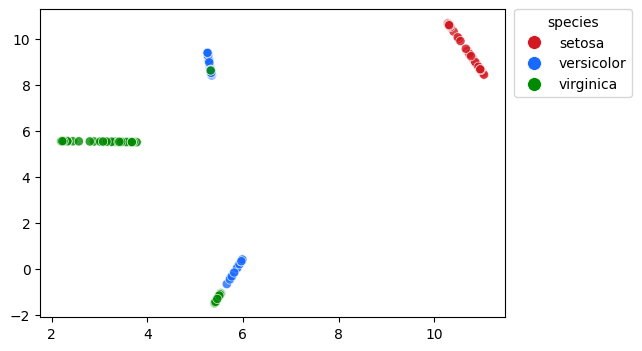

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.7839999999999999), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.70928025), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.7208888888888888), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.7493333333333332), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=nan, info={'metric': 'euclidean', 'n_neighbors': 150})]

In [3]:
pl.standard_eval(
    custom_umap(SQUMAP, "SqUMAP"),
    dataset="iris",
    extra_plot={"show_axes": True},
)

/home/james/dev/drnb3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


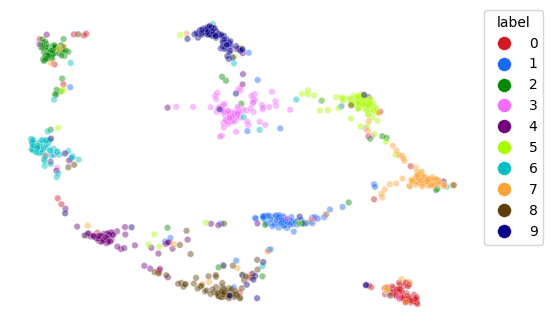

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.5882000000000001), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.26117587), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.34979999999999994), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.4543), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.5117333333333334), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [4]:
pl.standard_eval(
    custom_umap(SQUMAP, "SqUMAP"),
    dataset="s1k",
)

/home/james/dev/drnb3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


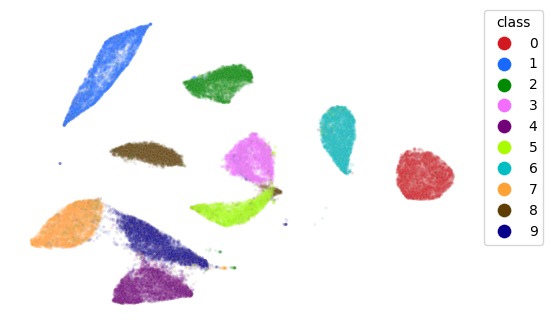

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.6084971428571428), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.3287232), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.10821428571428572), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.1716262857142857), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.2584435238095238), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [5]:
pl.standard_eval(
    custom_umap(SQUMAP, "SqUMAP"),
    dataset="mnist",
)

/home/james/dev/drnb3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


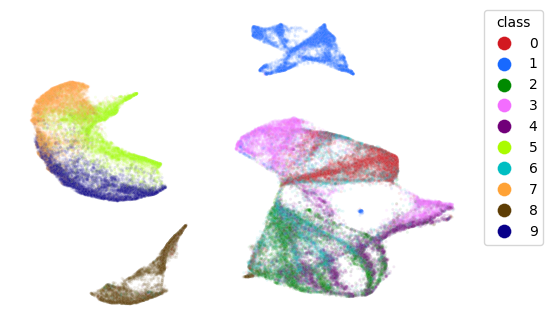

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.7270142857142857), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.59294957), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.11701428571428568), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.18537914285714288), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.27538142857142855), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [6]:
pl.standard_eval(
    custom_umap(SQUMAP, "SqUMAP"),
    dataset="fashion",
)